# final results with systematical uncetainties

In [1]:
import sys; sys.path.insert(0, '../../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
%precision 3
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/systematics/'

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


# save the differences as systematical uncertainties into a csv

## GENIE models cross-sections

In [2]:
Xsec_dicts_genie = dict()
with open(Paths['1d Xsec'] + "Pmu_genie_Xsecs_1D.txt", 'rb') as infile:
    Xsec_dicts_genie['mu'] = pickle.load(infile)
with open(Paths['1d Xsec'] + "Pp_genie_Xsecs_1D.txt", 'rb') as infile:
    Xsec_dicts_genie['p'] = pickle.load(infile)

## cross-section + statistical uncertainties

In [3]:
Xsec_results_dicts = dict()
with open(Paths['1d Xsec'] + "PmuXsecs_1D.txt", 'rb') as infile:
    Xsec_results_dicts['mu'] = pickle.load(infile)
with open(Paths['1d Xsec'] + "PpXsecs_1D.txt", 'rb') as infile:
    Xsec_results_dicts['p'] = pickle.load(infile)

## systematical uncertainties

In [4]:
with open(Paths['systematics'] + "cut_sensitivty_systemaitcal_uncertainty.txt", 'rb') as infile: 
    Xsec_sys_unc_cuts = pickle.load(infile)
with open(Paths['systematics'] + "beam_flux_uncertainty_systemaitcal_uncertainty.txt", 'rb') as infile: 
    Xsec_sys_unc_beam_flux = pickle.load(infile)
POT_unc = 0.02 # 2% (proton flux measured in the two toroids agree to within 2%...)

## now draw the cross-sections

In [23]:
def draw_Xsecs(do_add_afro_genie = True, debug=0, particle='mu',do_with_ctu_bin=False,
               do_P=True, do_cos_theta=True, do_phi=True,figsize=(24,10),
               residuals_ylim=[-1,1],residuals_yticks=[-0.5,0,0.5],residuals_ytitle=1.05,residuals_xtitle='center'):
    
    Xsec_dicts = Xsec_results_dicts[particle]
    Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]

    
    figurename = 'Xsec_1D_P'+particle 
    for iXsec,(Xsec_title,Xsec_fname,remove_ctu_bin) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,remove_ctu_bools)):#{
        if remove_ctu_bin==False and do_with_ctu_bin==False: continue
            
        Xsec_dict = Xsec_dicts[Xsec_title]
        Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

        fig=plt.figure(figsize=figsize)
        for i,(observable,true,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']                                                        
                                                                 ,['truth_P'+particle,'truth_P'+particle+'_cos_theta','truth_P'+particle+'_phi']
                                                                 ,[(1,4),(2,5),(3,6)]
                                                                 ,[do_P,do_cos_theta,do_phi])):
            if do_var==False: continue
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            if remove_ctu_bin and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]

            ax = fig.add_subplot(3,3,ivar)
            ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay') 
            if do_add_afro_genie:#{
                for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
                    mystep(x=mid ,x_width=bin_width, 
                           y=Xsec_genie_dict[gname+' '+observable], 
                           y_width=Xsec_genie_dict[gname+' '+observable+' err'],
                           color='black',linestyle=ls,linewidth=3,label=glabel)
                #}
            #}
            
            # ---------------------------------------- # 
            # systematical uncertainties
            Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,Xsec_sys_unc_beam_flux=Xsec_sys_unc_beam_flux,var=var,Xsec_fname=Xsec_fname,h=h)
            if debug:
                print 'Xsec_sys_unc_cuts_up,Xsec_sys_unc_flux_up,Xsec_sys_unc_up:',Xsec_sys_unc_cuts_up,Xsec_sys_unc_flux_up,Xsec_sys_unc_up
                print 'Xsec_sys_unc_up:',Xsec_sys_unc_up
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data') # data
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=[Xsec_tot_unc_dw,Xsec_tot_unc_up],color=Colors['beam on'],fmt='o',markersize=0,capsize=10,capthick=3) # + syst. uncertainties

            # ---------------------------------------- # 
            # axes labels
            set_axes(ax,'',y_label=get_Xsec_label(vlabel=vlabel,units=units),fontsize=23
                         ,do_add_grid=True,remove_ticks_x=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                         ,ylim=(0,1.1*np.max(ax.get_ylim()))
                        )
            plt.title(Xsec_title, y=1.02,fontsize=25)
            if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')


                
            # ---------------------------------------- # 
            # residuals plot
            Xsec_tot_unc = np.sqrt( 0.5*(np.square(Xsec_tot_unc_dw) + np.square(Xsec_tot_unc_up)) )
            data,data_err = h['Xsec'],Xsec_tot_unc
            MC,MC_err = h['mc Xsec'],h['mc Xsec err']

            den, den_err = data-MC,np.sqrt(np.square(data_err)+np.square(MC_err))
            num, num_err = data,data_err
            ratio = den/num
            ax = fig.add_subplot(3,3,7+i)
            ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
            plt.errorbar(x=mid,xerr=0,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black',capsize=10,capthick=3)
            chi2,ndf = chi2_two_data_curves(h1=data,h1err=data_err,h2=MC,h2err=MC_err,bins=bins,debug=debug)
            set_axes(ax,xlabel,y_label=r'(data-MC)/data' if i==0 else '',
                     do_add_grid=True,ylim=residuals_ylim,yticks=residuals_yticks)
            plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')
            plt.title(r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20,y=residuals_ytitle,loc=residuals_xtitle)
            if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')                    
        #}
        plt.tight_layout(h_pad=0.0)
        plt.subplots_adjust(hspace=0.05)
        save_figure(figures_path + figurename + '_' + Xsec_fname + '.pdf')
    return 

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/systematics/Xsec_1D_Pmu_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/systematics/Xsec_1D_Pmu_with_last_ctu_bin.pdf


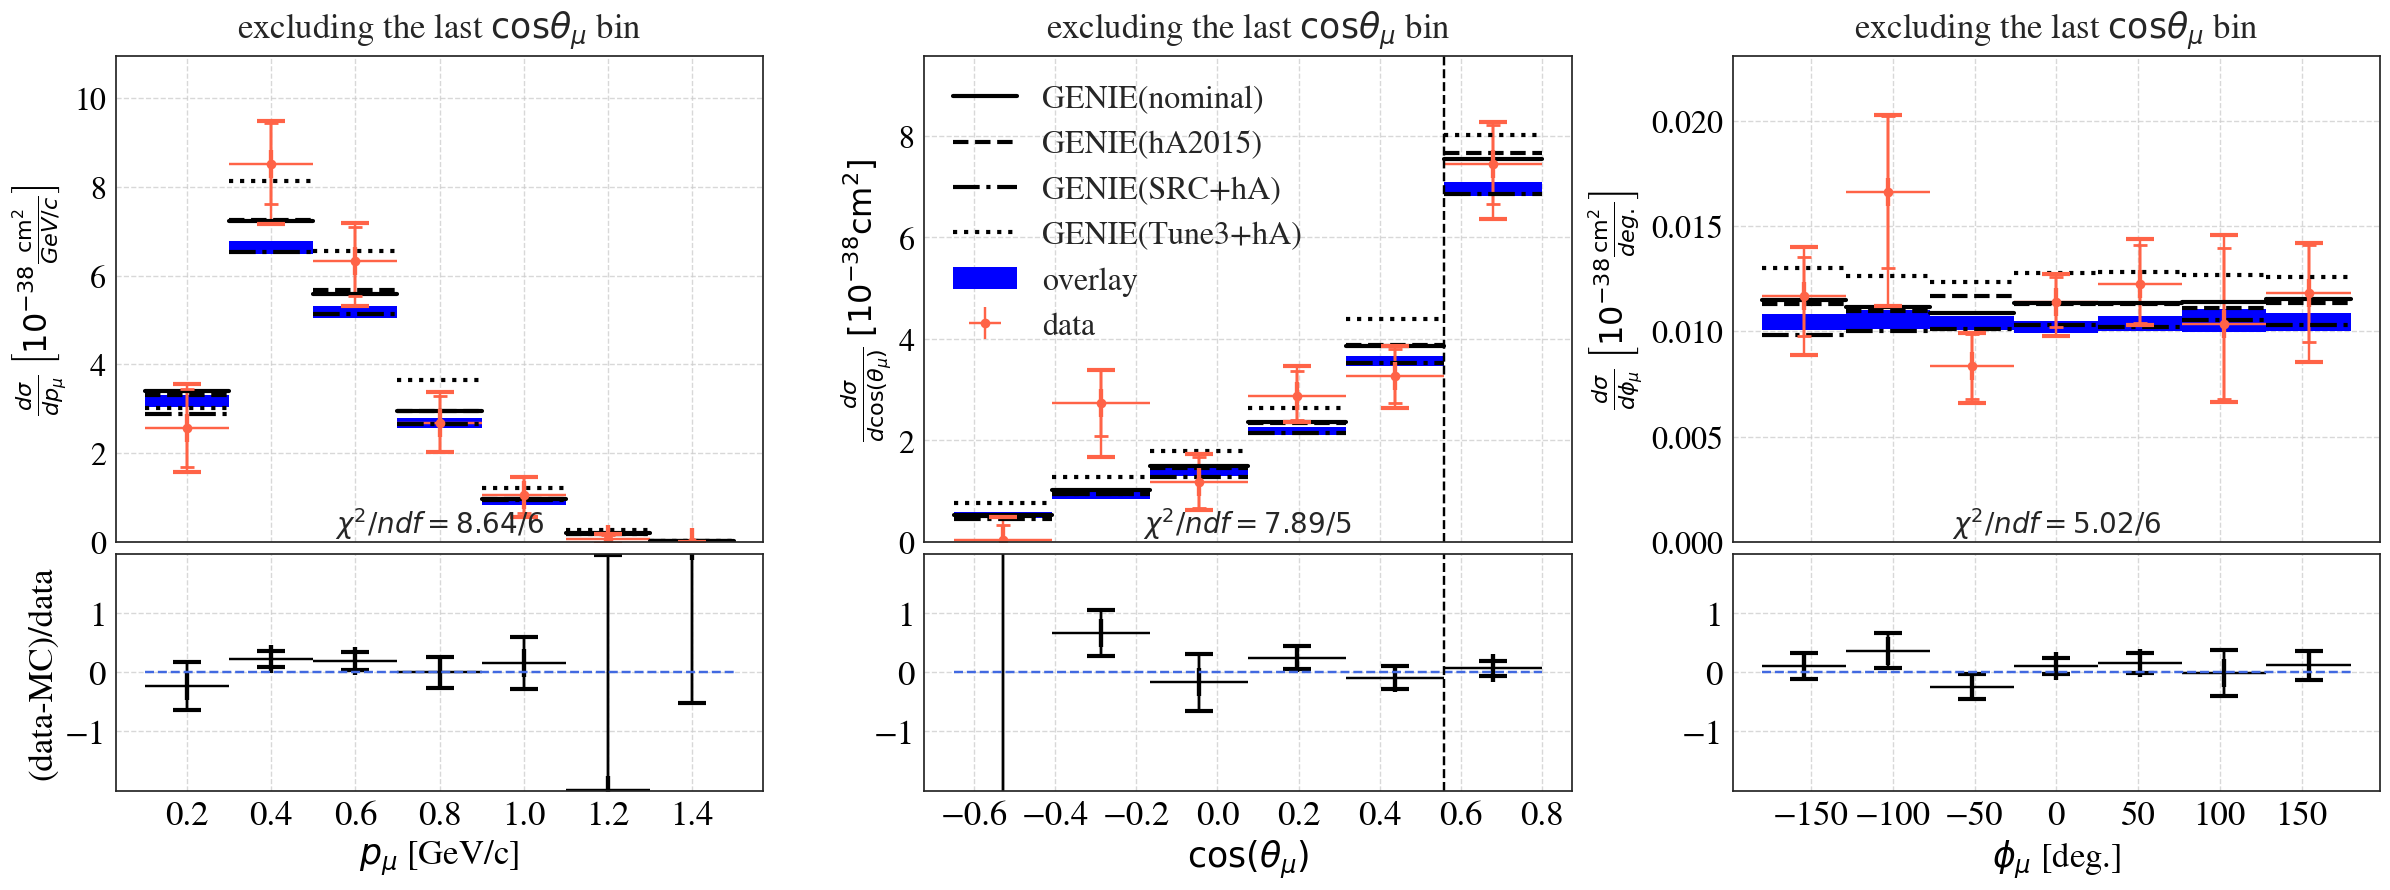

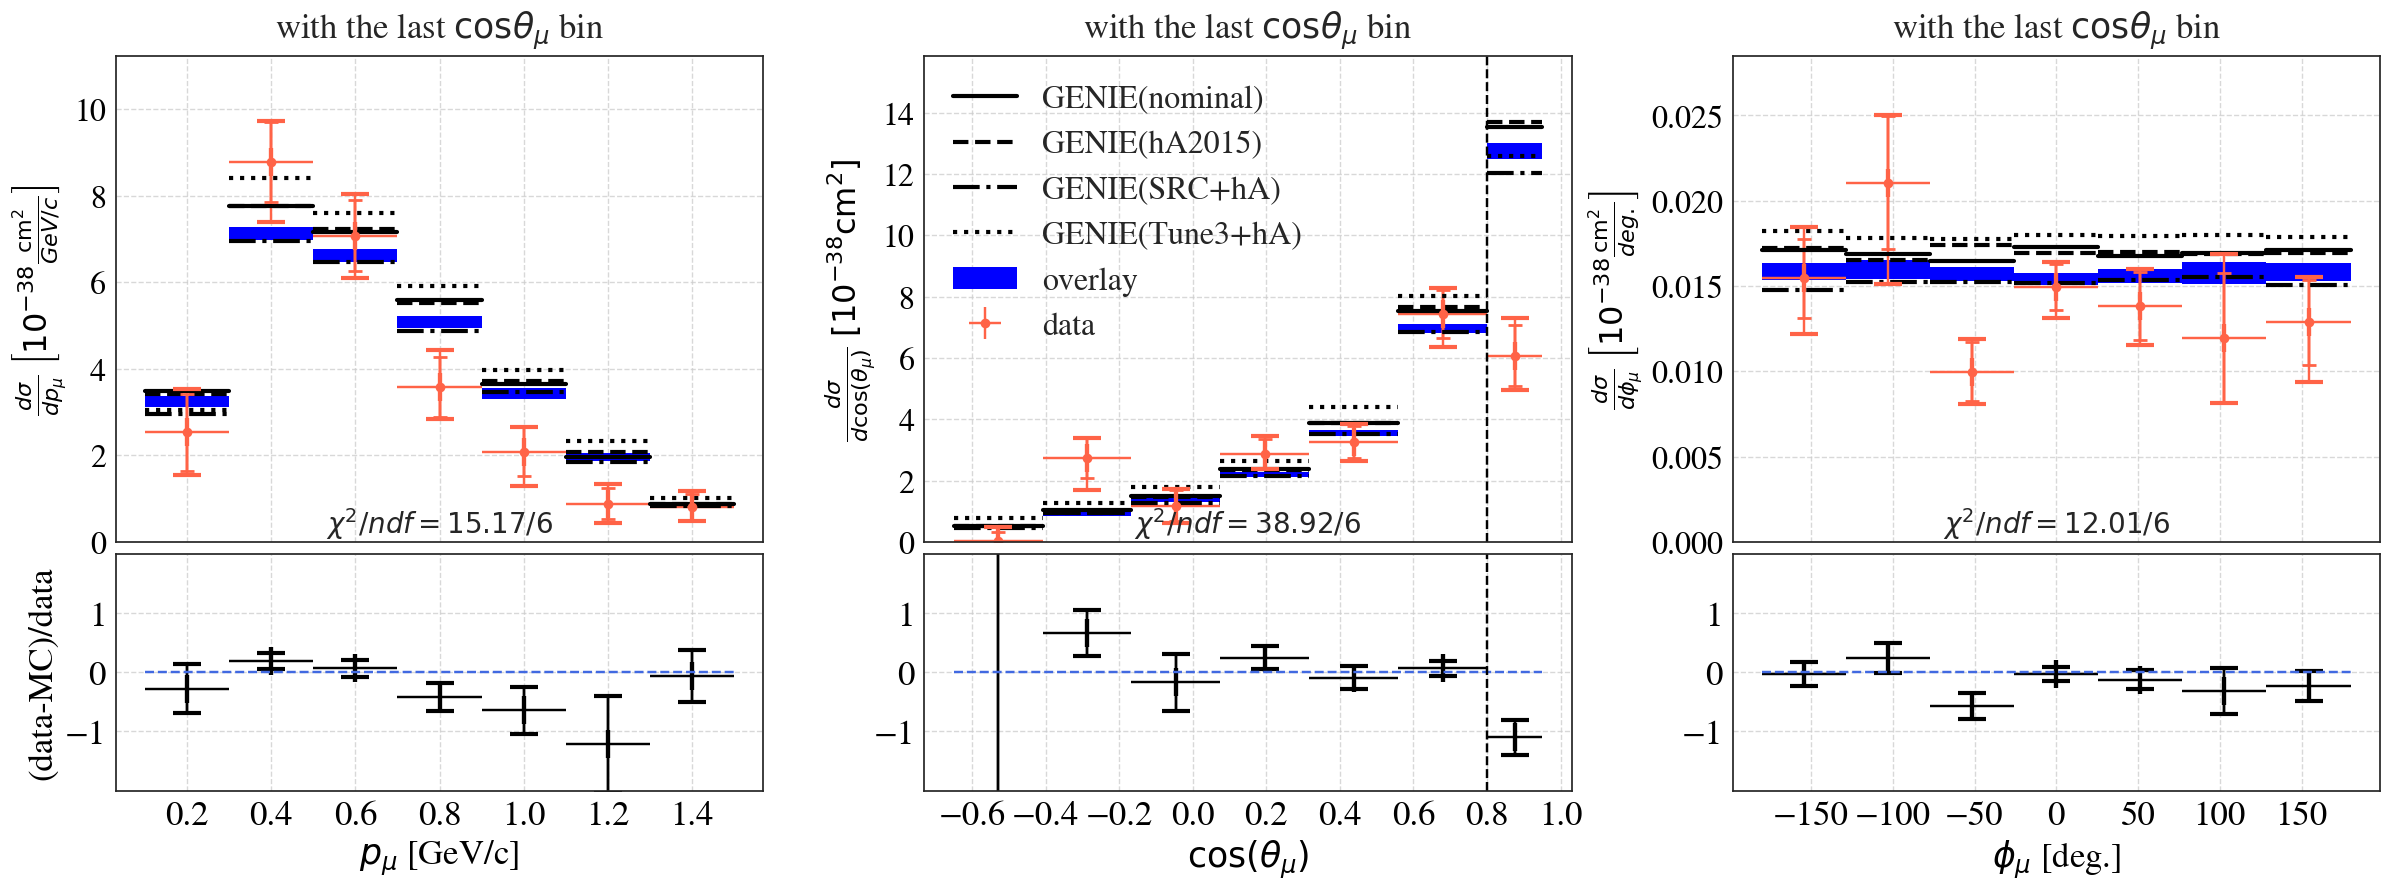

In [24]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='mu', do_P=True, do_cos_theta=True, do_phi=True,figsize=(24,9),do_with_ctu_bin=True,
           residuals_ylim=[-2,2],residuals_yticks=[-1,0,1])

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/systematics/Xsec_1D_Pp_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/systematics/Xsec_1D_Pp_with_last_ctu_bin.pdf


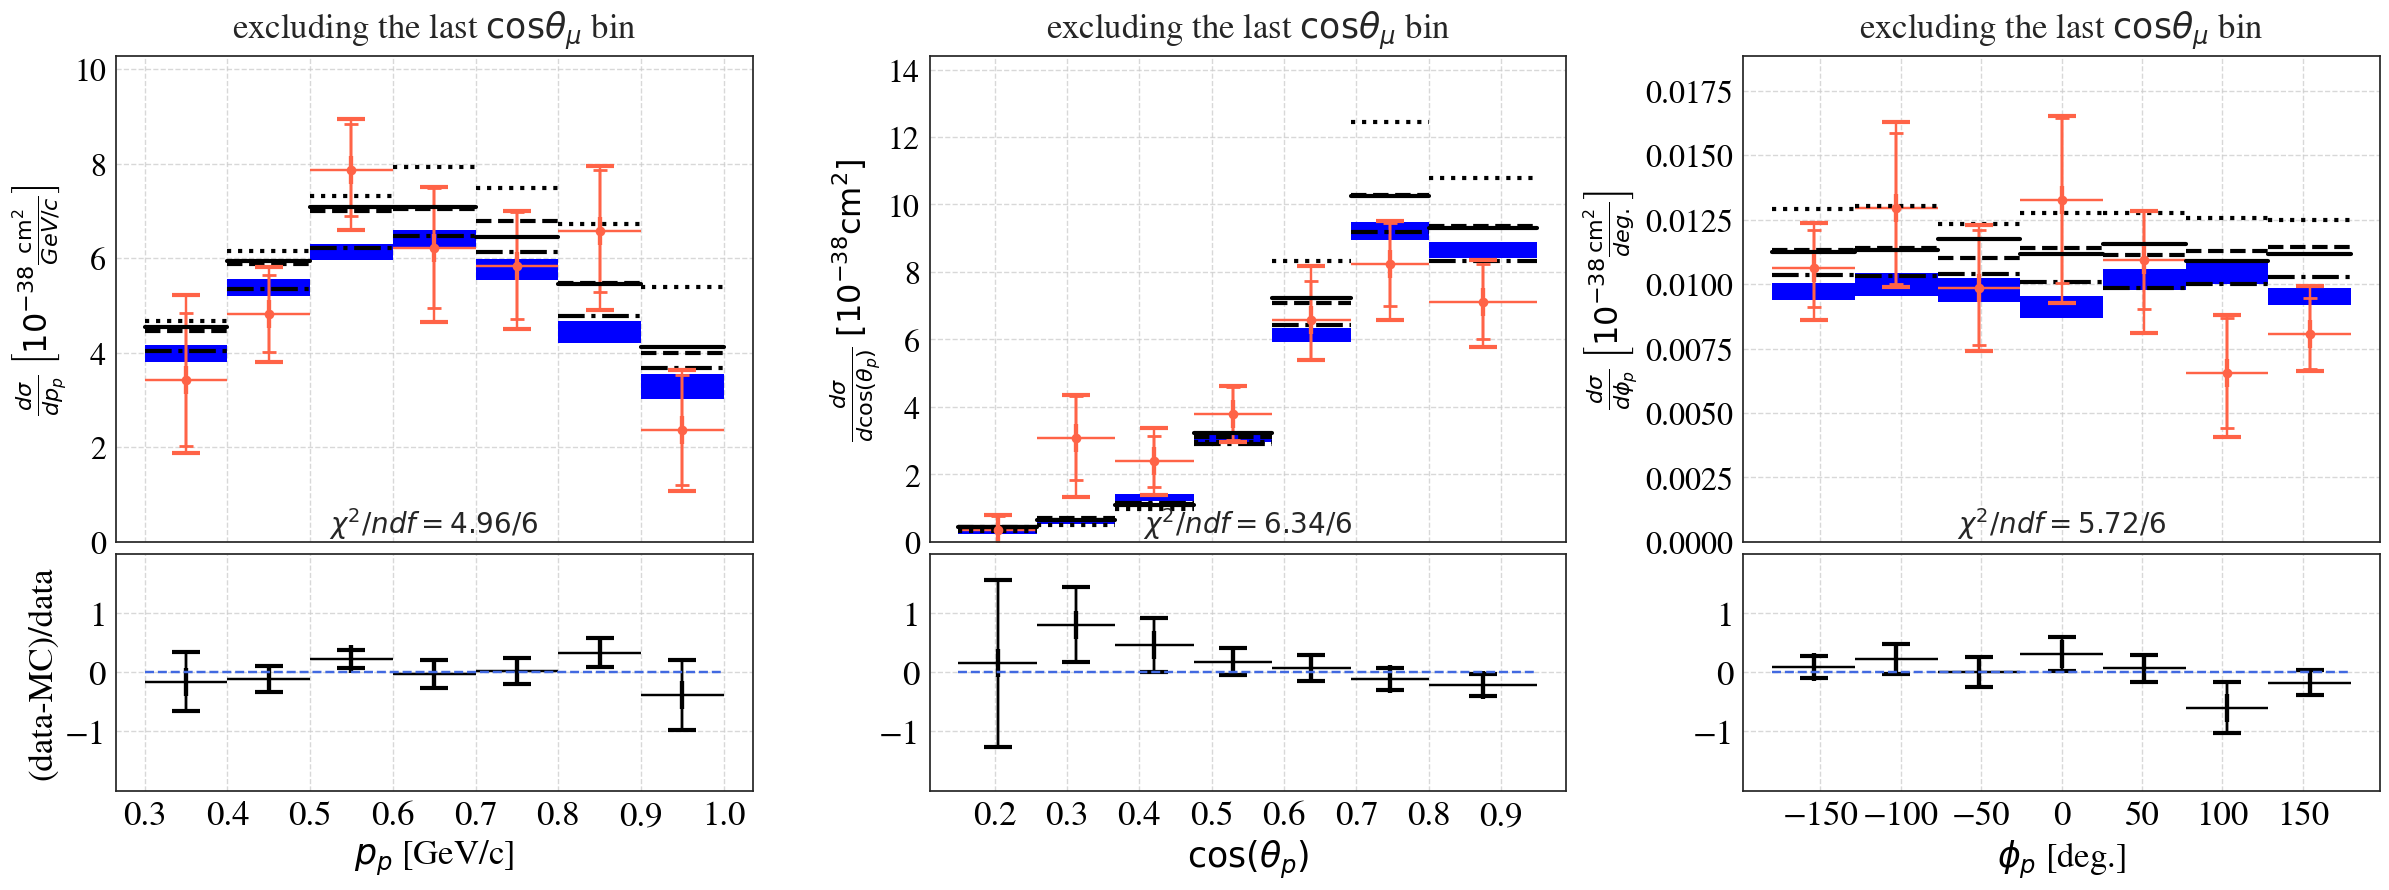

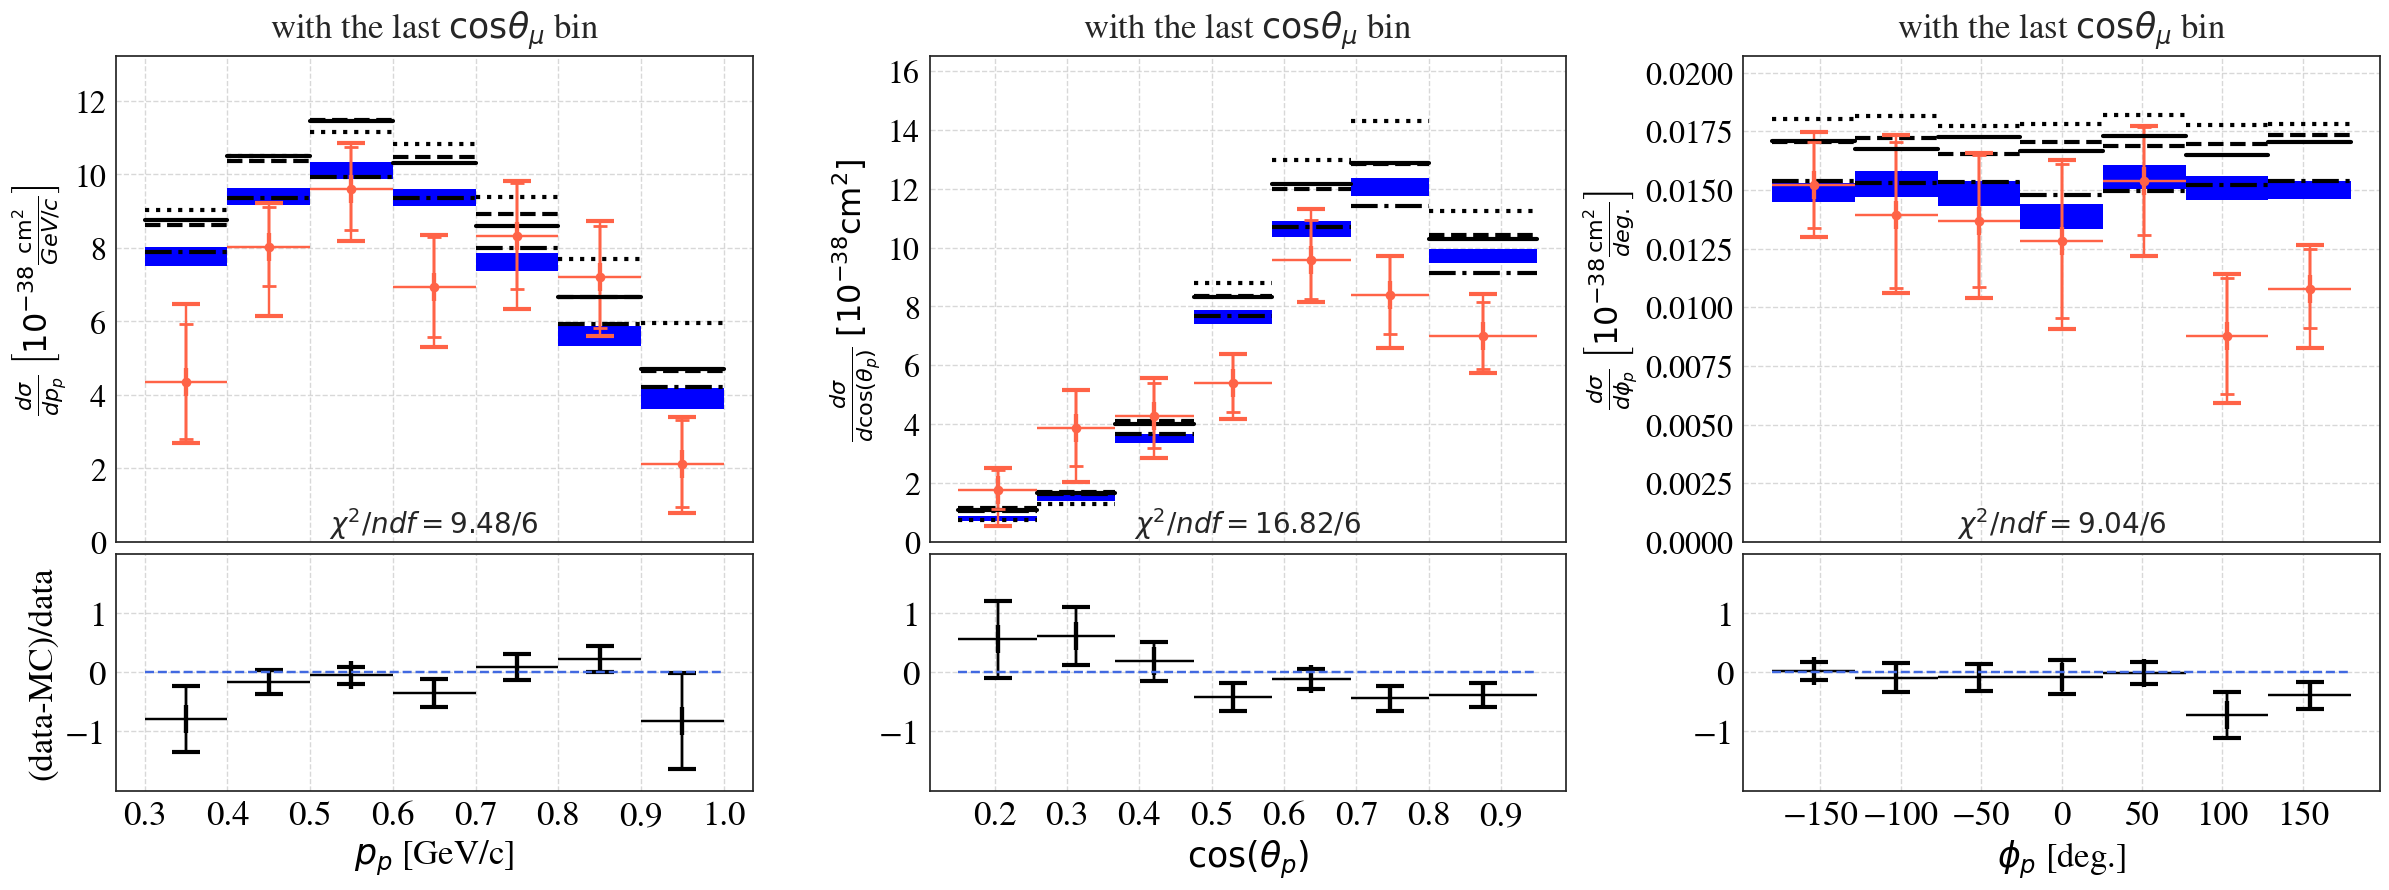

In [25]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='p', do_P=True, do_cos_theta=True, do_phi=True,figsize=(24,9),do_with_ctu_bin=True,
           residuals_ylim=[-2,2],residuals_yticks=[-1,0,1])

## total cross-section

In [8]:
# muon dependent cross-section
def get_total_Xsec(do_add_afro_genie=True, debug=0, particle='mu',do_with_ctu_bin=False):
    
    Xsec_dicts = Xsec_results_dicts[particle]
    Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]

    for iXsec,(Xsec_title,Xsec_fname,remove_ctu_bin) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,remove_ctu_bools)):#{
        if remove_ctu_bin==False and do_with_ctu_bin==False: continue
            
        Xsec_dict = Xsec_dicts[Xsec_title]
        Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]
    
        Xsec = Xsec_dict['integrated Xsec']
        stat_err = Xsec_dict['integrated Xsec err']
        overlay_Xsec = Xsec_dict['mc Xsec']
        overlay_stat_err = Xsec_dict['mc Xsec err']

        
        observable='P'+particle
        var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
        h = dict()
        h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
        h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
          
        # ---------------------------------------- # 
        # systematical uncertainties
        Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,Xsec_sys_unc_beam_flux=Xsec_sys_unc_beam_flux,var=var,Xsec_fname=Xsec_fname,h=h)
        h['Xsec sys err up'] = np.sqrt( np.square(Xsec_sys_unc_cuts_up) + np.square(Xsec_sys_unc_flux_up) + np.square(Xsec_sys_unc_POT_up) )
        h['Xsec sys err dw'] = np.sqrt( np.square(Xsec_sys_unc_cuts_dw) + np.square(Xsec_sys_unc_flux_dw) + np.square(Xsec_sys_unc_POT_dw) )
        h['Xsec tot err up'] = np.sqrt( np.square(h['Xsec sys err up']) + np.square(h['Xsec err']) )
        h['Xsec tot err dw'] = np.sqrt( np.square(h['Xsec sys err dw']) + np.square(h['Xsec err']) )
        
        sys_err_up = np.sum( h['Xsec sys err up']*bin_width )
        sys_err_dw = np.sum( h['Xsec sys err dw']*bin_width )
        tot_err_up = np.sum( h['Xsec tot err up']*bin_width )
        tot_err_dw = np.sum( h['Xsec tot err dw']*bin_width )
            
        
        print (r'\sigma_{CC1p\pi} = %.2f'%Xsec + r'\pm (%.2f'%stat_err + ')_{stat.} + (^{+%.2f} _{-%.2f}'%(sys_err_up,sys_err_dw)+')_{sys.} '
               + '=' 
               + '%.2f'%Xsec + ' + (^{+%.2f} _{-%.2f}'%(tot_err_up,tot_err_dw) + ') \\times 10^{-38} \\textrm{cm}^2')
        print (r'\sigma_{overlay} = %.2f'%overlay_Xsec + r'\pm (%.2f'%overlay_stat_err + ')_{stat.}'+'\\times 10^{-38} \\textrm{cm}^2')

        
        if do_add_afro_genie:#{
            for gname,glabel in zip(genie_list,genie_labels):#{
                print (r'\sigma_{\textrm{'+glabel+'}} = %.2f'%Xsec_dicts_genie['mu'][Xsec_ctu_titles[0]][gname+' Xsec'] 
                       + r'\pm %.2f'%Xsec_dicts_genie['mu'][Xsec_ctu_titles[0]][gname+' Xsec err'] +' \\times 10^{-38} \\textrm{cm}^2')
            #}
        #}
    return Xsec,tot_err_up,tot_err_dw

In [9]:
Xsec,tot_err_up,tot_err_dw = get_total_Xsec(do_add_afro_genie=True, debug=0, particle='mu',do_with_ctu_bin=False)

\sigma_{CC1p\pi} = 4.24\pm (0.74)_{stat.} + (^{+0.29} _{-0.52})_{sys.} =4.24 + (^{+0.80} _{-0.92}) \times 10^{-38} \textrm{cm}^2
\sigma_{overlay} = 3.75\pm (0.12)_{stat.}\times 10^{-38} \textrm{cm}^2
\sigma_{\textrm{GENIE(nominal)}} = 4.07\pm 0.03 \times 10^{-38} \textrm{cm}^2
\sigma_{\textrm{GENIE(hA2015)}} = 4.06\pm 0.03 \times 10^{-38} \textrm{cm}^2
\sigma_{\textrm{GENIE(SRC+hA)}} = 3.67\pm 0.03 \times 10^{-38} \textrm{cm}^2
\sigma_{\textrm{GENIE(Tune3+hA)}} = 4.57\pm 0.03 \times 10^{-38} \textrm{cm}^2


# tabulated results for the appendix of my thesis

In [92]:
def x_string(x,var):
    if 'cos' in var:
        return '%.2f'%x if x>=0 else '(%.2f)'%x
    elif 'phi' in var:
        return '%.1f'%x if x>=0 else '(%.1f)'%x
    else:
        return '%.1f'%x
    
def Xsec_string(Xsec,Xsec_stat_unc,Xsec_sys_unc_up=None,Xsec_sys_unc_dw=None,i_bin=0,var='Pmu'):
    if 'phi' in var:
        if Xsec_sys_unc_up is not None and Xsec_sys_unc_dw is not None:
            return '$%.4f \pm %.4f_{stat.} (^{+%.4f} _{-%.4f})_{sys.}$'%(Xsec[i_bin],Xsec_stat_unc[i_bin],Xsec_sys_unc_up[i_bin], Xsec_sys_unc_dw[i_bin])
        else:
            return '$%.4f \pm %.4f$'%(Xsec[i_bin],Xsec_stat_unc[i_bin])
    else:
        if Xsec_sys_unc_up is not None and Xsec_sys_unc_dw is not None:
            return '$%.2f \pm %.2f_{stat.} (^{+%.2f} _{-%.2f})_{sys.}$'%(Xsec[i_bin],Xsec_stat_unc[i_bin],Xsec_sys_unc_up[i_bin], Xsec_sys_unc_dw[i_bin])    
        else: 
            return '$%.2f \pm %.2f$'%(Xsec[i_bin],Xsec_stat_unc[i_bin]) 

In [104]:
def print_Xsecs_to_table(debug=0, particle='mu'):
    
    Xsec_dicts = Xsec_results_dicts[particle]
    Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]
    
    for iXsec,(Xsec_title,Xsec_fname,remove_ctu_bin) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,remove_ctu_bools)):#{
            
        print '\multicolumn{3}{c}{' + Xsec_title + '}' +r' \tabularnewline'+'\n'+r' \hline'

        
        Xsec_dict = Xsec_dicts[Xsec_title]
        Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

        for i,observable in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
            h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
            if remove_ctu_bin and var=='reco_Pmu_cos_theta':
                mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
                h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
                h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]
            (Xsec_sys_unc_up, Xsec_sys_unc_dw,
             Xsec_tot_unc_up, Xsec_tot_unc_dw) = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,
                                                                       Xsec_sys_unc_beam_flux=Xsec_sys_unc_beam_flux,
                                                                       var=var,
                                                                       Xsec_fname=Xsec_fname,h=h)

            print (xlabel + '\t'+ '&' + '\t' 
                   + get_Xsec_label(vlabel=vlabel,units=units) + '\t'+ '&' + '\t'                                      
                   + r'overlay prediction \tabularnewline'                                             
                   +r' \hline')
            for i_bin in range(len(bins)-1):
                x1 = bins[i_bin]
                x2 = bins[i_bin+1]
                
                
                print ('%s-%s'%(x_string(x1,var),x_string(x2,var)) + '\t'+ '&' + '\t'
                       +Xsec_string(h['Xsec'],h['Xsec err'],Xsec_sys_unc_up,Xsec_sys_unc_dw,i_bin,var)+ '\t'+ '&' + '\t'
                       +Xsec_string(h['mc Xsec'],h['mc Xsec err'],i_bin=i_bin,var=var)
                       +r' \tabularnewline'                      
                       +'\n'
                       +r' \hline')
            print 
        #}
    return

In [105]:
print_Xsecs_to_table(particle='mu')

\multicolumn{3}{c}{excluding the last $\cos\theta_\mu$ bin} \tabularnewline
 \hline
$p_{\mu}$ [GeV/c]	&	$\frac{d\sigma}{dp_{\mu}}$ $\left[10^{- 38} \frac{\mathrm{cm}^{2}}{GeV/c} \right]$	&	overlay prediction \tabularnewline \hline
0.1-0.3	&	$2.56 \pm 0.88_{stat.} (^{+0.45} _{-0.46})_{sys.}$	&	$3.17 \pm 0.14$ \tabularnewline
 \hline
0.3-0.5	&	$8.52 \pm 0.91_{stat.} (^{+0.27} _{-1.00})_{sys.}$	&	$6.63 \pm 0.15$ \tabularnewline
 \hline
0.5-0.7	&	$6.32 \pm 0.78_{stat.} (^{+0.34} _{-0.64})_{sys.}$	&	$5.18 \pm 0.14$ \tabularnewline
 \hline
0.7-0.9	&	$2.67 \pm 0.62_{stat.} (^{+0.32} _{-0.16})_{sys.}$	&	$2.69 \pm 0.11$ \tabularnewline
 \hline
0.9-1.1	&	$1.06 \pm 0.40_{stat.} (^{+0.02} _{-0.29})_{sys.}$	&	$0.89 \pm 0.07$ \tabularnewline
 \hline
1.1-1.3	&	$0.06 \pm 0.10_{stat.} (^{+0.03} _{-0.02})_{sys.}$	&	$0.18 \pm 0.03$ \tabularnewline
 \hline
1.3-1.5	&	$-0.01 \pm 0.01_{stat.} (^{+0.01} _{-0.00})_{sys.}$	&	$0.02 \pm 0.01$ \tabularnewline
 \hline

$\cos(\theta_{\mu})$	&	$\frac{d\sigma}{d\cos(\

In [106]:
print_Xsecs_to_table(particle='p')

\multicolumn{3}{c}{excluding the last $\cos\theta_\mu$ bin} \tabularnewline
 \hline
$p_{p}$ [GeV/c]	&	$\frac{d\sigma}{dp_{p}}$ $\left[10^{- 38} \frac{\mathrm{cm}^{2}}{GeV/c} \right]$	&	overlay prediction \tabularnewline \hline
0.3-0.4	&	$3.43 \pm 1.41_{stat.} (^{+1.12} _{-0.65})_{sys.}$	&	$3.98 \pm 0.19$ \tabularnewline
 \hline
0.4-0.5	&	$4.83 \pm 0.82_{stat.} (^{+0.57} _{-0.63})_{sys.}$	&	$5.38 \pm 0.17$ \tabularnewline
 \hline
0.5-0.6	&	$7.87 \pm 0.97_{stat.} (^{+0.47} _{-0.81})_{sys.}$	&	$6.13 \pm 0.18$ \tabularnewline
 \hline
0.6-0.7	&	$6.22 \pm 1.27_{stat.} (^{+0.20} _{-0.91})_{sys.}$	&	$6.40 \pm 0.20$ \tabularnewline
 \hline
0.7-0.8	&	$5.85 \pm 1.14_{stat.} (^{+0.19} _{-0.71})_{sys.}$	&	$5.76 \pm 0.21$ \tabularnewline
 \hline
0.8-0.9	&	$6.58 \pm 1.29_{stat.} (^{+0.45} _{-1.05})_{sys.}$	&	$4.44 \pm 0.23$ \tabularnewline
 \hline
0.9-1.0	&	$2.37 \pm 1.17_{stat.} (^{+0.52} _{-0.56})_{sys.}$	&	$3.28 \pm 0.26$ \tabularnewline
 \hline

$\cos(\theta_{p})$	&	$\frac{d\sigma}{d\cos(\theta_{

# look at the difference between $\sigma_{stat.}$ and $\sigma_{tot.}$ for example in one figure

chi2,ndf: 8.63945503659 6


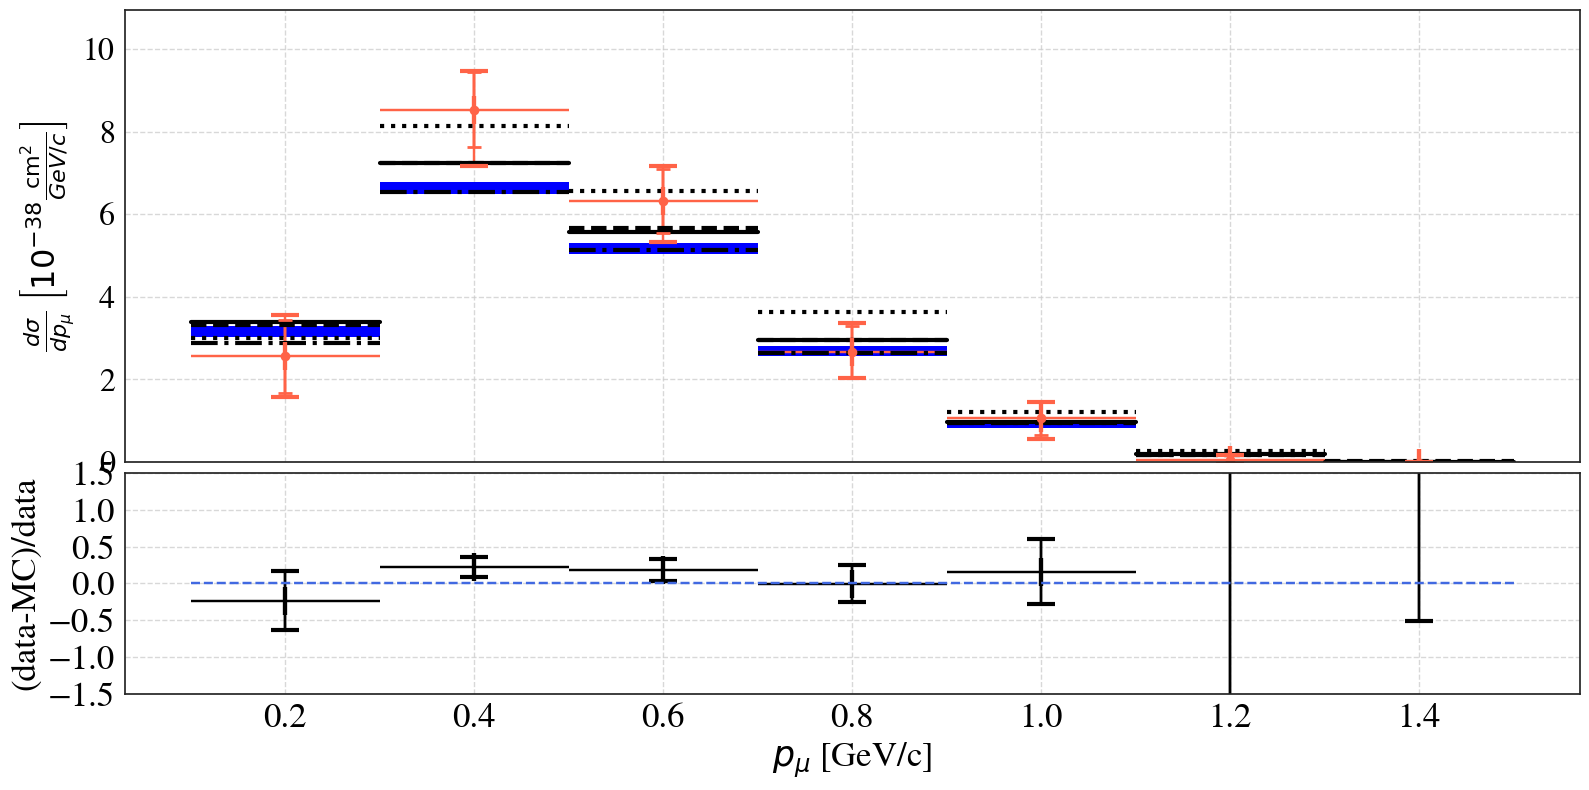

In [22]:
particle = 'mu'
Xsec_dicts = Xsec_results_dicts[particle]
Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]

Xsec_title = Xsec_ctu_titles[0]
Xsec_fname = Xsec_fnames[0]
remove_ctu_bin = remove_ctu_bools[0]
Xsec_dict = Xsec_dicts[Xsec_title]
Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

fig=plt.figure(figsize=(16,8))
observable,true = 'P'+particle,'truth_P'+particle
var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
h = dict()
h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
if remove_ctu_bin and var=='reco_Pmu_cos_theta':
    mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
    h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
    h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]

ax = fig.add_subplot(3,1,(1,2))
ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay') 
for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
    mystep(x=mid ,x_width=bin_width, 
    y=Xsec_genie_dict[gname+' '+observable], 
    y_width=Xsec_genie_dict[gname+' '+observable+' err'],
    color='black',linestyle=ls,linewidth=3,label=glabel)
#}
            
# ---------------------------------------- # 
Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,Xsec_sys_unc_beam_flux=Xsec_sys_unc_beam_flux,var=var,Xsec_fname=Xsec_fname,h=h)
plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data') # data
plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties
plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=[Xsec_tot_unc_dw,Xsec_tot_unc_up],color=Colors['beam on'],fmt='o',markersize=0,capsize=10,capthick=3) # + syst. uncertainties

set_axes(ax,'',y_label=get_Xsec_label(vlabel=vlabel,units=units),fontsize=23
                         ,do_add_grid=True,remove_ticks_x=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                         ,ylim=(0,1.1*np.max(ax.get_ylim()))
                        )
# ---------------------------------------- # 
# residuals plot
Xsec_tot_unc = np.sqrt( 0.5*(np.square(Xsec_tot_unc_dw) + np.square(Xsec_tot_unc_up)) )
data,data_err = h['Xsec'],Xsec_tot_unc
MC,MC_err = h['mc Xsec'],h['mc Xsec err']

den, den_err = data-MC,np.sqrt(np.square(data_err)+np.square(MC_err))
num, num_err = data,data_err
ratio = den/num
ax = fig.add_subplot(3,1,3)
ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
plt.errorbar(x=mid,xerr=0,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black',capsize=10,capthick=3)
chi2,ndf = chi2_two_data_curves(h1=data,h1err=data_err,h2=MC,h2err=MC_err,bins=bins,debug=debug)
print 'chi2,ndf:',chi2,ndf
set_axes(ax,xlabel,y_label=r'(data-MC)/data',do_add_grid=True,ylim=(-1.5,1.5))
plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')
# plt.title(r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20,y=0.88)
if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')                    
#}
plt.tight_layout(h_pad=0.0)
plt.subplots_adjust(hspace=0.05)


chi2,ndf: 11.6618495239 6


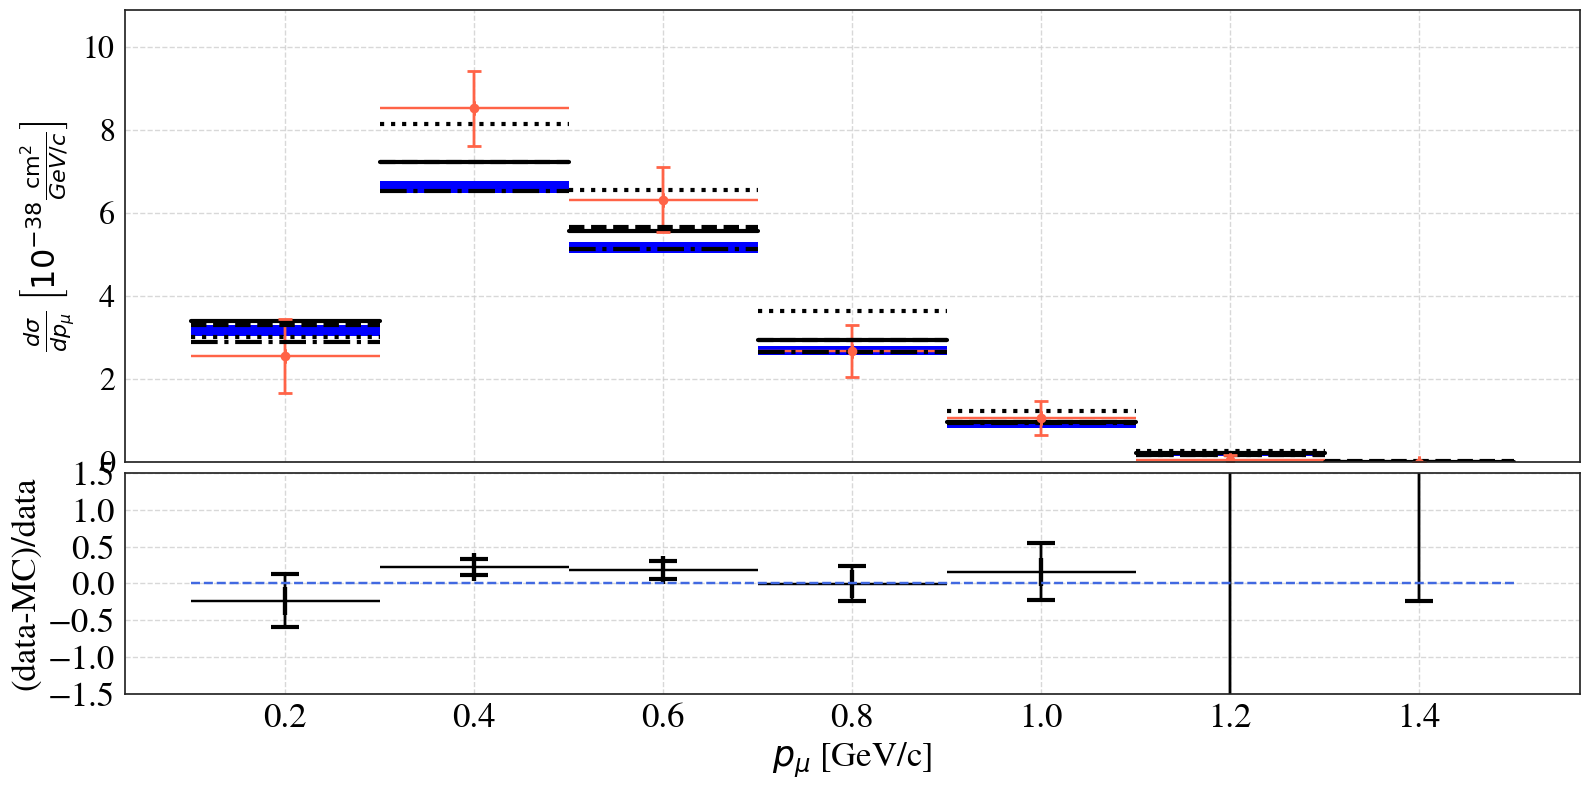

In [21]:
particle = 'mu'
Xsec_dicts = Xsec_results_dicts[particle]
Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]

Xsec_title = Xsec_ctu_titles[0]
Xsec_fname = Xsec_fnames[0]
remove_ctu_bin = remove_ctu_bools[0]
Xsec_dict = Xsec_dicts[Xsec_title]
Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

fig=plt.figure(figsize=(16,8))
observable,true = 'P'+particle,'truth_P'+particle
var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
h = dict()
h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']
if remove_ctu_bin and var=='reco_Pmu_cos_theta':
    mid=mid[:-1]; bin_width=bin_width[:-1]; bins=bins[:-1]
    h['Xsec']=h['Xsec'][:-1];h['Xsec err']=h['Xsec err'][:-1]
    h['mc Xsec']=h['mc Xsec'][:-1];h['mc Xsec err']=h['mc Xsec err'][:-1]

ax = fig.add_subplot(3,1,(1,2))
ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay') 
for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
    mystep(x=mid ,x_width=bin_width, 
    y=Xsec_genie_dict[gname+' '+observable], 
    y_width=Xsec_genie_dict[gname+' '+observable+' err'],
    color='black',linestyle=ls,linewidth=3,label=glabel)
#}
            
# ---------------------------------------- # 
plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data') # data
plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties

set_axes(ax,'',y_label=get_Xsec_label(vlabel=vlabel,units=units),fontsize=23
                         ,do_add_grid=True,remove_ticks_x=True,do_add_legend=True if 'Pmu_cos_theta' in var else False
                         ,ylim=(0,1.1*np.max(ax.get_ylim()))
                        )
# ---------------------------------------- # 
# residuals plot
Xsec_tot_unc = np.sqrt( np.square(Xsec_tot_unc_dw) + np.square(Xsec_tot_unc_up) )
data,data_err = h['Xsec'],h['Xsec err']
MC,MC_err = h['mc Xsec'],h['mc Xsec err']

den, den_err = data-MC,np.sqrt(np.square(data_err)+np.square(MC_err))
num, num_err = data,data_err
ratio = den/num
ax = fig.add_subplot(3,1,3)
ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
plt.errorbar(x=mid,xerr=0,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black',capsize=10,capthick=3)
chi2,ndf = chi2_two_data_curves(h1=data,h1err=data_err,h2=MC,h2err=MC_err,bins=bins,debug=debug)
print 'chi2,ndf:',chi2,ndf
set_axes(ax,xlabel,y_label=r'(data-MC)/data',do_add_grid=True,ylim=(-1.5,1.5))
plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')
# plt.title(r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20,y=0.88)
if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='black')                    
#}
plt.tight_layout(h_pad=0.0)
plt.subplots_adjust(hspace=0.05)